#**ECE 4554 / ECE 5554 / Computer Vision**
This file contains the coding problems (Problems 4, 5, and 6) for Homework 4. Your job is to implement/modify the sections within this notebook that are marked with "TO DO".

##**TO DO**: Enter your Virginia Tech Username (PID) here: benakhtar
Do not write a student ID number. Your Username is normally part of your @vt.edu email address.

##**Honor Code**

Once again, please review the Honor Code statement in the syllabus.  This is not a "team project".  *If you make use of code from ANY source except the instructor, you must provide comment lines in your programs to state where you obtained that code.* Failure to cite sources of code that you borrowed will be considered a violation of the Honor Code.

##**Code libraries**
For all of these problems, you are allowed to use library functions (OpenCV, NumPy, SciPy, Matplotlib, etc.) to perform file I/O, matrix operations, and graphics/plotting operations such as `cv2.circle` and `cv2.line`. The individual problems also name some library functions that you are allowed to use, such as getRectSubPix in Problem 4 and SIFT-related functions in Problem 5. Do not use other library functions without permission from the instructor.

You may re-use any code that *you* have written for previous assignments, especially the homography-related code that you developed for Problem 2.

##**Submission guidelines** for the coding problems (Google Colab)

1. Please verify that you have entered your Virginia Tech Username in all of the appropriate places.
2. After your solutions are complete, click Runtime->"Restart and run all"; then verify that all of your solutions are visible in this notebook.
3. Click File->Save near the top of the page to save the latest version of your notebook at Google Drive.
4. Verify that the last 2 cells have executed, creating a PDF version of this notebook at Google Drive. (Note: if you face difficulty with this step, please refer to https://pypi.org/project/notebook-as-pdf/)
5. Look at the PDF file and check that all of your solutions are displayed correctly there.
6. Download your notebook file and the PDF version to your laptop.
7. If needed, change the file names to Homework4_USERNAME.ipynb and Homework4_
Notebook_USERNAME.pdf, using your own Username. Don’t zip either of the files.
8. **Submit these 2 files along with your PDF file for Problems 1-3 SEPARATELY to Canvas.** Do not zip them all together.

##**Overview**

This assignment asks you to explore 2 main topics:  visual tracking, and the use of SIFT-style keypoints for object detection.

Problem 4 -- visual tracking using the KLT method.

Problem 5 -- object detection and localization using SIFT keypoints.

Problem 6 -- ***optional for all students*** -- implement your own SIFT-style descriptor; or perform a comparison of SIFT vs. other descriptors such as ORB.

# Environment setup

In [12]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Change the directory to your own working directory
# Any files under your working directory are available to your code
# TO DO: enter the name of your directory
import os
os.chdir('/content/drive/MyDrive/Computer Vision')


In [14]:
# Import library modules
import sys
import cv2 # OpenCV library
from PIL import Image  # Python Imaging Library
import numpy as np
import matplotlib.pyplot as plt

# (Note: we would use cv2.imshow if running on your laptop;
#  cv2.imshow is not allowed in Colab, so use cv2_imshow instead)
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)


Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
OpenCV version: 4.8.0
NumPy version:  1.23.5


#Problem 4 - KLT tracking

You have been given a folder that contains the "hotel" image sequence. This sequence is a set of 51 images: `hotel.seq00.png`, ..., `hotel.seq50.png`. If you display them in quick succession you will see a toy hotel undergo rotation and a small amount of translation. Keep these files inside the folder `hotel_images`, and upload that folder to your working directory at Colab.

The purpose of this problem is to implement KLT tracking over the hotel image sequence. Use the following code block to verify a correct upload to Google Drive, and to illustrate keypoint detection. This code finds Shi-Tomasi keypoints in image 0 of the sequence, and indicates their locations by small yellow circles.




Number of detected keypoints = 161


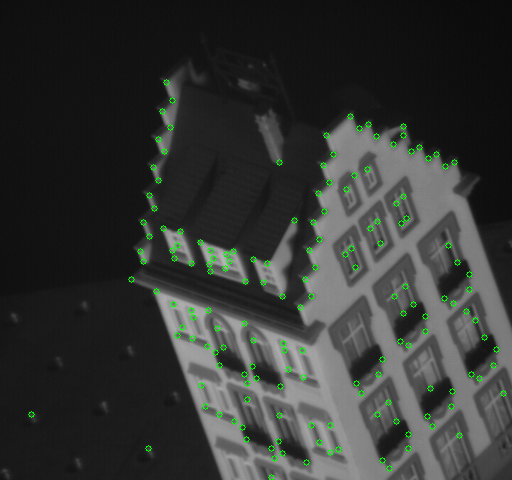

In [15]:
# The purpose of this code block is to verify that you can access the hotel
#  images, and to illustrate examples of keypoints.
#  Parts of this example were borrowed from
#  https://docs.opencv.org/4.x/d4/d8c/tutorial_py_shi_tomasi.html

DISPLAY_RADIUS = 3
DISPLAY_COLOR  = (0, 255, 0)

def keypointDetectionDemo(im0):
  # Find image locations that may be good for tracking
  feature_params = dict( maxCorners = 300,
                       qualityLevel = 0.2,
                       minDistance = 7,
                       blockSize = 5 )
  p0 = cv2.goodFeaturesToTrack(im0, mask = None, **feature_params)
  # Now p0 should contain an array of (floating point) pixel locations
  if p0 is None:
    print("no keypoints were found!")
    return
  print (f'Number of detected keypoints = {p0.shape[0]}')

  # Convert to k x 2 format, where k is the number of feature points
  corners = np.zeros((p0.shape[0],2))
  for i in range(corners.shape[0]):
    corners[i] = p0[i][0]

  # Draw a small circle at each detected point and display the result
  im0color = cv2.cvtColor(im0, cv2.COLOR_GRAY2BGR)
  cornersInt = np.intp(np.round(corners)) # convert to integers used for indexing
  for i in cornersInt:
    x, y = i.ravel()      # returns a contiguous flattened array as (column, row)
    cv2.circle(im0color, (x, y), DISPLAY_RADIUS, DISPLAY_COLOR)

  cv2_imshow(im0color)
  return

# Load and display a sample image, detect features, and display the results
im0 = cv2.imread("hotel_images/hotel.seq00.png", cv2.COLOR_BGR2GRAY)
keypointDetectionDemo(im0)


# Tracking

Write code that will apply the Kanade-Lucas-Tomasi (KLT) procedure to track the keypoints that were detected in the previous code example. Those keypoints were detected in image 0 of the hotel sequence, and the goal is to track them throughout images 1 to 50.

The KLT procedure operates on a pair of images that were captured at times t and t+1. For a given keypoint at (x, y) at time t, the procedure tries to find the new location (x', y') of the same keypoint at time t+1.  For reference, the following pseudocode is from the lecture slides.  
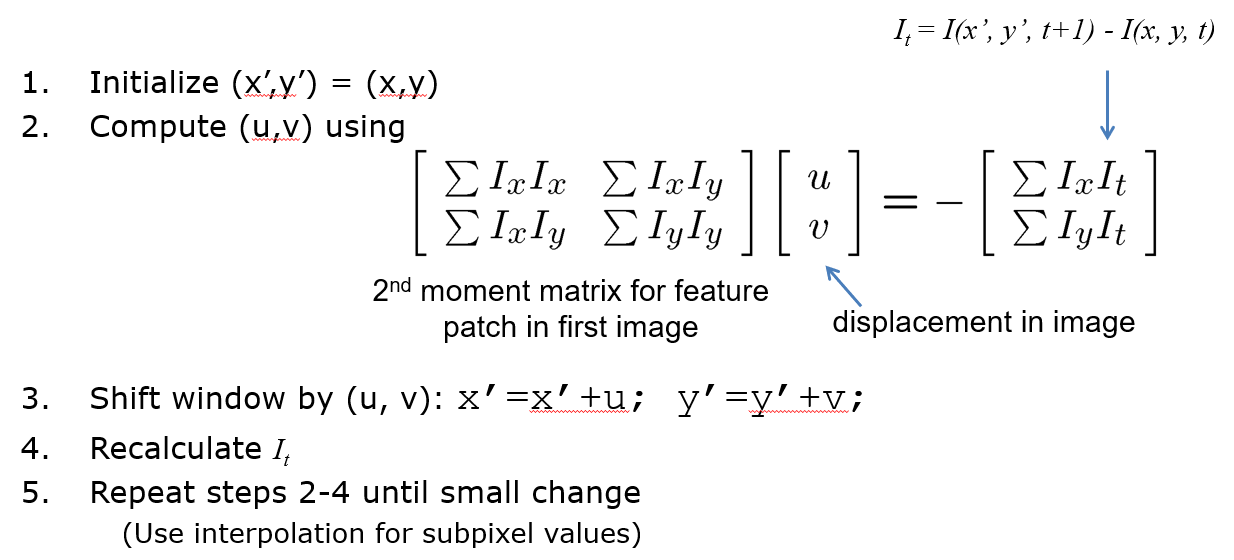


The KLT tracking procedure assumes small movements of keypoints from t to t+1. For this reason, tracking needs to be performed at subpixel resolution. Keypoint locations therefore need to be maintained using floating point values.

*This part was not discussed in class, and should help you obtain better results.* The matrix equation depends on spatial gradients, which can be noisy. For this reason, you should perform smoothing of the spatial gradients when computing these matrices.

You *are* allowed to use the OpenCV function `getRectSubPix`, which takes an image location at subpixel resolution, and interpolates neighboring pixel values to return a small region of interest from the image. For computing the summations in the pseudocode, it is suggested that you use a window size of 15x15 surrounding the keypoint. You are allowed to use low-level NumPy functions such as `np.sum` and `np.multiply`.




The first function that you should implement is **`getNextPoints`** in the next code block. It should apply the KLT procedure using a pair of images for a given collection of feature points. For each feature point in an image at time t, the procedure tries to find the location of the corresponding point in an image at time t+1.

It is likely that some of the keypoints will eventually move out of the image frame as they are tracked over the entire sequence. To handle these situations in a simple way, it is suggested that you maintain a `movedOutFlag` vector of True/False values. If an element in `movedOutFlag` is False, then the associated keypoint is inside the image frame and should be processed; but if True, then your function `getNextPoints` should ignore that keypoint.

In [16]:
###################################
import math

def getNextPoints(im1, im2, xy, movedOutFlag):
    '''Track keypoints from image im1 to image im2
     Input:
      im1: grayscale image at time t; shape (m, n)
      im2: grayscale image at time t+1; shape (m, n)
      xy:  a numpy array of size k by 2, where k is the number of keypoints
       Each keypoint is of the form [x, y], with both x==column and y==row in floating-point format
     Output:
      xy2: updated keypoint locations; same format as xy input
      movedOutFlag: array of True/False values, of size k by 1,
       to indicate whether each associated
       keypoint has moved outside the dimensions of the image array

     TO DO: Implement the function.
    '''
    print("In function getNextPoints")

    # copy xy2 to start
    xy2 = np.copy(xy).astype(float)

    # sets images as float for getRectSubPix
    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)

    # Calculates Ix and Iy using custom gradient function. Found that sobel was having issue with this task, but taking the gradient did not
    Ix, Iy =  gradient(im1)

    # For every point in our keypoints
    for point in range(len(xy)):

      # gets the patch x and patch y centered on the keypoints
      sub_x = cv2.getRectSubPix(Ix, (15,15), (xy[point,0], xy[point,1]))
      sub_y = cv2.getRectSubPix(Iy, (15,15), (xy[point,0], xy[point,1]))

      # gives us A
      Ixx = np.sum(sub_x * sub_x)
      Iyy = np.sum(sub_y * sub_y)
      Ixy = np.sum(sub_x * sub_y)
      A = np.array([[Ixx, Ixy], [Ixy, Iyy]])

      # sets up our u, v for sum of squard differences
      u = 1
      v = 1

      ssd = math.sqrt(u**2 + v **2)

      #while ssd > .01:
      # found a while loop was taking too long to run, so set this 100 and still get reasonable results
      for x in range(0, 100):
        sub_t = cv2.getRectSubPix(im2, (15,15), (xy2[point,0], xy2[point,1])) - cv2.getRectSubPix(im1, (15, 15), (xy[point,0], xy[point,1]))

        Ixt = np.sum(sub_x * sub_t)
        Iyt = np.sum(sub_y * sub_t)
        # gives us B
        B = np.array([[-Ixt],[-Iyt]])

        # gets our u and v matrix
        uv = np.matmul(np.linalg.pinv(A), B)

        u = uv[0]
        v = uv[1]

        # Updates the xy2 matrix with our new points
        xy2[point] = [xy2[point,0] + u, xy2[point,1] + v]

        ssd = math.sqrt(u**2 + v **2)
        if ssd <= .01:
          break

    # Checks our moved out flag to keep track if the point has moved out of the image
    if xy2[point,0] >= len(im1) or xy2[point,1] >= len(im1[0]) or xy2[point,1] < 0 or xy2[point,0] < 0:
      movedOutFlag[point] = 1

    return(xy2, movedOutFlag)

# Implements numpy.gradient custom method rebuilt from scratch
def gradient(img_in):

  # Creates our Ix, Iy
  Ix = np.empty(([len(img_in), len(img_in[0])]), dtype=np.float32)
  Iy = np.empty(([len(img_in), len(img_in[0])]), dtype=np.float32)

  # Loops through row and columns to build our gradients for each row and column wise
  for row in range(0, len(img_in) - 2):
    for col in range(0, len(img_in[0])):
      if (row + 2) <= (len(img_in) - 1):
        if row == 0:
          grad_y_1 =  img_in[row + 1, col] - img_in[row, col]
          grad_y_2 = (img_in[row + 2, col] - img_in[row, col])/2

          Iy[row, col]     = grad_y_1
          Iy[row + 1, col] = grad_y_2

        elif row + 2 == len(img_in) - 1:
          grad_y_1 = (img_in[row + 2, col] - img_in[row, col])/2
          grad_y_2 =  img_in[row + 1, col] - img_in[row, col]

          Iy[row + 1, col] = grad_y_1
          Iy[row + 2, col] = grad_y_2

        else:
          grad_y_1 = (img_in[row + 2, col] - img_in[row, col])/2

          Iy[row + 1, col] = grad_y_1

      if (col + 2) <= (len(img_in[0]) - 1):
        if col == 0:
          grad_x_1 =  img_in[row, col + 1] - img_in[row, col]
          grad_x_2 = (img_in[row, col + 2] - img_in[row, col])/2

          Ix[row, col]     = grad_x_1
          Ix[row, col + 1] = grad_x_2

        elif col + 2 == len(img_in[0]) - 1:
          grad_x_1 = (img_in[row, col + 2] - img_in[row, col])/2
          grad_x_2 =  img_in[row, col + 1] - img_in[row, col]

          Ix[row, col + 1] = grad_x_1
          Ix[row, col + 2] = grad_x_2

        else:
          grad_x_1 = (img_in[row, col + 2] - img_in[row, col])/2

          Ix[row, col + 1] = grad_x_1

  # returns Ix, Iy
  return Ix, Iy


#Tracking test #1

Use the following code block to test your `getNextPoints` function using only a few keypoints. If your code is working correctly, then this test should display the keypoints at correct locations in both images.

Don't change this code block. (If you would like to add more tests for debugging, copy this code block into a new one and make your changes there.)


In function getNextPoints
initial keypoints = [[192. 263.]
 [245. 281.]
 [ 31. 414.]]
updated keypoints = [[192.1550293  263.11035156]
 [245.32032776 281.31216431]
 [ 27.4515934  412.80001831]]
updated flag = [0. 0. 0.]


<ipython-input-16-6dce1afbbff4>:67: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  xy2[point] = [xy2[point,0] + u, xy2[point,1] + v]


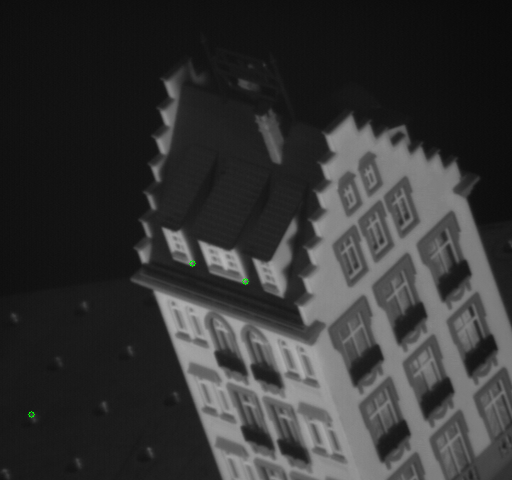

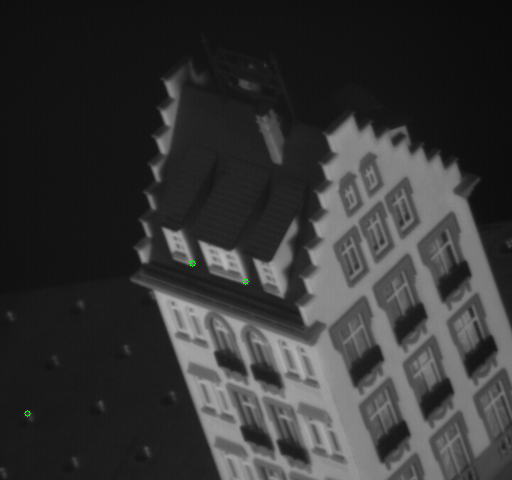

In [17]:
# Test getNextPoints with only a few keypoints, and with only one pair of images

im1 = cv2.imread("hotel_images/hotel.seq00.png", cv2.COLOR_BGR2GRAY)
im2 = cv2.imread("hotel_images/hotel.seq01.png", cv2.COLOR_BGR2GRAY)
# a few example keypoints
xy = np.array([[192., 263.], [245., 281.], [ 31., 414.]])
# initialize this flag to False, to indicate that all keypoints are inside the image
movedOutFlag = np.zeros(xy.shape[0])

xy2, movedOutFlag = getNextPoints(im1, im2, xy, movedOutFlag)
print (f'initial keypoints = {xy}')
print (f'updated keypoints = {xy2}')
print (f'updated flag = {movedOutFlag}')

# For both images, draw a small circle at each keypoint and display the result
DISPLAY_RADIUS = 3
DISPLAY_COLOR = (0, 255, 0)
im1color = cv2.cvtColor(im1, cv2.COLOR_GRAY2BGR)
corners = np.intp(np.round(xy))
for i in corners:
  x, y = i.ravel()
  cv2.circle(im1color, (x, y), DISPLAY_RADIUS, DISPLAY_COLOR)
cv2_imshow(im1color)

im2color = cv2.cvtColor(im2, cv2.COLOR_GRAY2BGR)
corners = np.intp(np.round(xy2))
for i in corners:
  x, y = i.ravel()
  cv2.circle(im2color, (x, y), DISPLAY_RADIUS, DISPLAY_COLOR)
cv2_imshow(im2color)

Now that you have tested your tracking code with on a small scale, it is time to work with more keypoints and longer image sequences.

The next code block provides a suggested structure for the overall tracking solution. The top-level function is **`mainTrackingFunction`**, which should generate the required results after you have finished. Examine this top-level function to see how the other functions fit together. Read the comment blocks for more detailed descriptions.

**Write additional code to complete the the next code block.** The only parts that you should need to update are marked "TO DO". The grader should only need to run `mainTrackingFunction` in order to generate and see your final KLT tracking results. Write the code so that it automatically displays the following:

*   images showing tracked keypoint locations for t=1 and t=11 and t=50, and possibly for a few more values of t (but do not display all of the images in your final output)
*   at the end, display image 0 that has been updated to show 2D paths that were taken by each keypoint during tracking (an example is given later)



(You are allowed to make further modifications to the code. But in those cases, please provide detailed comments to explain your reasons for making the changes.)




In [18]:
DISPLAY_RADIUS = 3
DISPLAY_COLOR  = (0, 255, 0)

def keypointDetection(im0):
  # Find image locations that may be good for tracking
  feature_params = dict( maxCorners = 300,
                       qualityLevel = 0.2,
                       minDistance = 7,
                       blockSize = 5 )
  p0 = cv2.goodFeaturesToTrack(im0, mask = None, **feature_params)
  # Now p0 should contain an array of (floating point) pixel locations
  if p0 is None:
    print("no keypoints were found!")
    return
  print (f'Number of detected keypoints = {p0.shape[0]}')

  # Convert to k x 2 format, where k is the number of feature points
  corners = np.zeros((p0.shape[0],2))
  for i in range(corners.shape[0]):
    corners[i] = p0[i][0]

  # Draw a small circle at each detected point and display the result
  im0color = cv2.cvtColor(im0, cv2.COLOR_GRAY2BGR)
  cornersInt = np.intp(np.round(corners)) # convert to integers used for indexing
  for i in cornersInt:
    x, y = i.ravel()      # returns a contiguous flattened array as (column, row)
    cv2.circle(im0color, (x, y), DISPLAY_RADIUS, DISPLAY_COLOR)

  cv2_imshow(im0color)
  return corners

In [20]:
# KLT TRACKING - main code block

# global variables - try to write you code without needing additional globals
NUMBER_OF_IMAGES = 51  # try smaller values here for initial testing
DISPLAY_RADIUS = 3
GREEN = (0, 255, 0)
YELLOW = (0, 255, 255)

def mainTrackingFunction():
  '''This is the main "driver" function that performs KLT tracking
  '''
  print("In mainTrackingFunction")
  allImgs = readImages(NUMBER_OF_IMAGES)
  print (f'number of images that were read = {len(allImgs)}')

  # get initial keypoints from image 0
  image0 = allImgs[0]
  xy = getKeypoints(image0)
  if xy is None:
    print("no points to track!")
    return
  print (f'number of detected keypoints = {xy.shape[0]}')

  # display keypoints for image 0
  image0color = cv2.cvtColor(image0, cv2.COLOR_GRAY2BGR)
  corners = np.intp(np.round(xy))
  for i in corners:
    x, y = i.ravel()
    cv2.circle(image0color, (x, y), DISPLAY_RADIUS, GREEN)

  # track the initial keypoints through all remaining images
  xyt = trackPoints(xy, allImgs)

  # in image 0, draw the paths taken by the keypoints
  drawPaths(image0color, xyt)
  return


def readImages(filecount):
  '''Read a sequence of image files, starting with image 0 in 'hotel' sequence
     Input:
      filecount: how many image files to read
     Output:
      allImages: a list of OpenCV images in sequential order
  '''
  print("In function readImages")
  allImages = []
  for i in range(filecount):
    print (f'reading image {i:02}')
    imagetmp = cv2.imread("hotel_images/hotel.seq" + f'{i:02d}' + ".png", cv2.COLOR_BGR2GRAY)
    allImages.append(imagetmp)
  return allImages


def getKeypoints(im0):
  '''Find keypoints that will be good for tracking;
     you are allowed to copy code directly from keypointDetectionDemo
     Input:
      im0: grayscale source image with shape (m, n)
     Output:
      corners: a numpy array of size kx2, where k is the number of keypoints.
       Each keypoint is of the form [x, y], where x and y are floating-point
       values that represent image locations in the (horizontal, vertical)
       directions, respectively.

     TO DO: Implement the getKeypoints function.
  '''
  # copied code to build keypoint detection
  corners = keypointDetection(im0)

  # will return our corners assuming they were found
  if corners is None:
    print("no keypoints were found!")
    return

  return corners


def trackPoints(xy, imageSequence):
  '''Track keypoints through the given image sequence
     Input:
      xy: a numpy array containing keypoints for the first image in imageSequence;
       format is identical to 'corners' in getKeypoints
      imageSequence: a list of OpenCV images in sequential order
     Output:
      xyt: <any format that you see fit, as needed by the drawPaths function>

     TO DO: Update the trackPoints function
  '''
  print ("In function trackPoints")
  print (f'length of imageSequence = {len(imageSequence)}')
  movedOutFlag = np.zeros(xy.shape[0])
  # initialize xyt to contain any information that is needed for drawing paths at the end of tracking
  # also add code in this function as needed to maintain xyt

  # xyt is initialized as a list, to which the new points from getNextPoints can be added
  xyt = []

  for t in range(0, len(imageSequence)-1): # predict for all images except first in sequence
    print (f't = {t}; predicting for t = {t+1}')
    xy2, movedOutFlag = getNextPoints(imageSequence[t], imageSequence[t+1], xy, movedOutFlag)
    xy = xy2

    # adds the points to xyt for each point in xy2
    for point in xy2:
      xyt.append(point)

    # for selected instants in time, display the latest image with highlighted keypoints
    if ((t == 0) or (t == 10) or (t == 20) or (t == 30) or (t == 40) or (t == 49)):
      im2color = cv2.cvtColor(imageSequence[t+1], cv2.COLOR_GRAY2BGR)
      corners = np.intp(np.round(xy2))

      for c in range(0, corners.shape[0]):
        if movedOutFlag[c] == False:
          x = corners[c][0]
          y = corners[c][1]
          cv2.circle(im2color, (x, y), DISPLAY_RADIUS, GREEN)
      cv2_imshow(im2color)

  return xyt

def drawPaths(im0color, xyt):
  '''In the given image, draw paths that were taken by each keypoint during tracking
     Input:
      im0color: a color image with shape (m, n, 3), typically the first image in a sequence
     Output:
      xyt: <any format that you see fit, as needed for drawing the paths>

     TO DO: Implement the drawPaths function
  '''
  print ("In function drawPaths")

  # for each point in xyt we draw a circle
  for point in xyt:
    im0color = cv2.circle(im0color, (round(point[0]),round(point[1])), radius=0, color=YELLOW, thickness=1)

  print ("FINISHED: here are the paths of the tracked keypoints")
  cv2_imshow(im0color)


#Tracking test #2

The grader should only need to run **`mainTrackingFunction`** in the next block in order to run your code and see the required output.

In mainTrackingFunction
In function readImages
reading image 00
reading image 01
reading image 02
reading image 03
reading image 04
reading image 05
reading image 06
reading image 07
reading image 08
reading image 09
reading image 10
reading image 11
reading image 12
reading image 13
reading image 14
reading image 15
reading image 16
reading image 17
reading image 18
reading image 19
reading image 20
reading image 21
reading image 22
reading image 23
reading image 24
reading image 25
reading image 26
reading image 27
reading image 28
reading image 29
reading image 30
reading image 31
reading image 32
reading image 33
reading image 34
reading image 35
reading image 36
reading image 37
reading image 38
reading image 39
reading image 40
reading image 41
reading image 42
reading image 43
reading image 44
reading image 45
reading image 46
reading image 47
reading image 48
reading image 49
reading image 50
number of images that were read = 51
Number of detected keypoints = 161


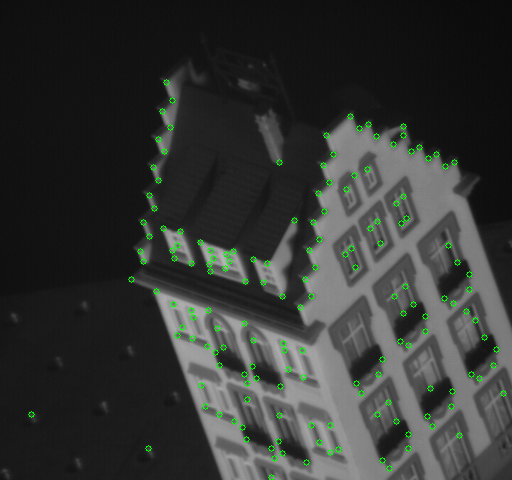

number of detected keypoints = 161
In function trackPoints
length of imageSequence = 51
t = 0; predicting for t = 1
In function getNextPoints


<ipython-input-16-6dce1afbbff4>:67: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  xy2[point] = [xy2[point,0] + u, xy2[point,1] + v]


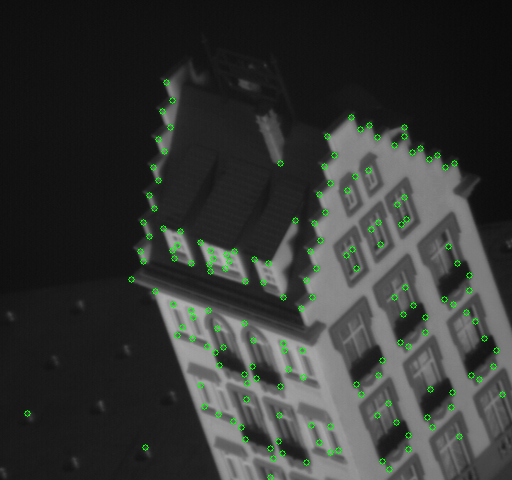

t = 1; predicting for t = 2
In function getNextPoints
t = 2; predicting for t = 3
In function getNextPoints
t = 3; predicting for t = 4
In function getNextPoints
t = 4; predicting for t = 5
In function getNextPoints
t = 5; predicting for t = 6
In function getNextPoints
t = 6; predicting for t = 7
In function getNextPoints
t = 7; predicting for t = 8
In function getNextPoints
t = 8; predicting for t = 9
In function getNextPoints
t = 9; predicting for t = 10
In function getNextPoints
t = 10; predicting for t = 11
In function getNextPoints


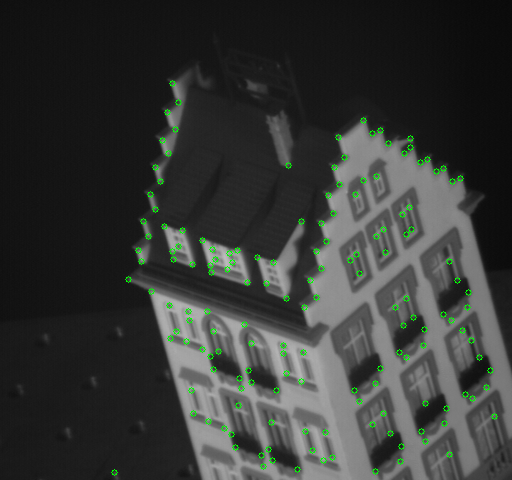

t = 11; predicting for t = 12
In function getNextPoints
t = 12; predicting for t = 13
In function getNextPoints
t = 13; predicting for t = 14
In function getNextPoints
t = 14; predicting for t = 15
In function getNextPoints
t = 15; predicting for t = 16
In function getNextPoints
t = 16; predicting for t = 17
In function getNextPoints
t = 17; predicting for t = 18
In function getNextPoints
t = 18; predicting for t = 19
In function getNextPoints
t = 19; predicting for t = 20
In function getNextPoints
t = 20; predicting for t = 21
In function getNextPoints


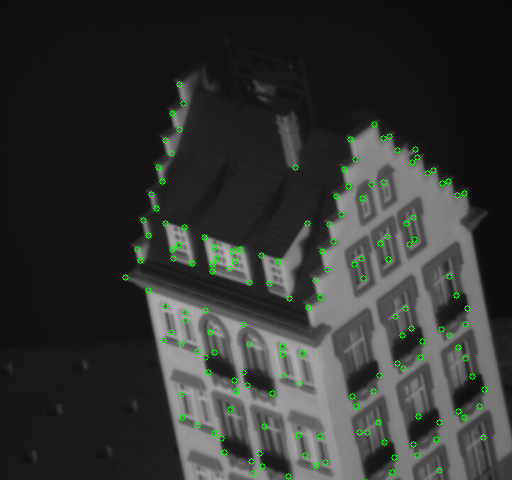

t = 21; predicting for t = 22
In function getNextPoints
t = 22; predicting for t = 23
In function getNextPoints
t = 23; predicting for t = 24
In function getNextPoints
t = 24; predicting for t = 25
In function getNextPoints
t = 25; predicting for t = 26
In function getNextPoints
t = 26; predicting for t = 27
In function getNextPoints
t = 27; predicting for t = 28
In function getNextPoints
t = 28; predicting for t = 29
In function getNextPoints
t = 29; predicting for t = 30
In function getNextPoints
t = 30; predicting for t = 31
In function getNextPoints


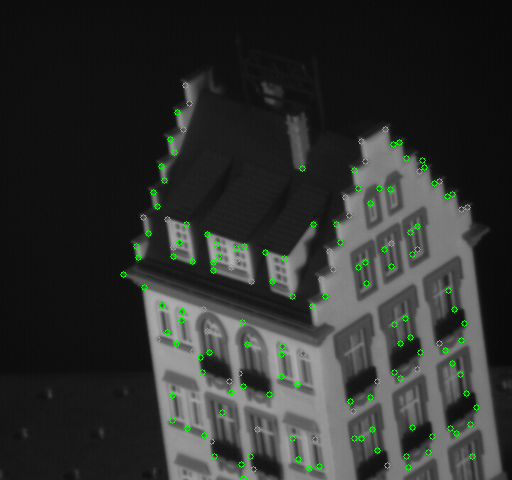

t = 31; predicting for t = 32
In function getNextPoints
t = 32; predicting for t = 33
In function getNextPoints
t = 33; predicting for t = 34
In function getNextPoints
t = 34; predicting for t = 35
In function getNextPoints
t = 35; predicting for t = 36
In function getNextPoints
t = 36; predicting for t = 37
In function getNextPoints
t = 37; predicting for t = 38
In function getNextPoints
t = 38; predicting for t = 39
In function getNextPoints
t = 39; predicting for t = 40
In function getNextPoints
t = 40; predicting for t = 41
In function getNextPoints


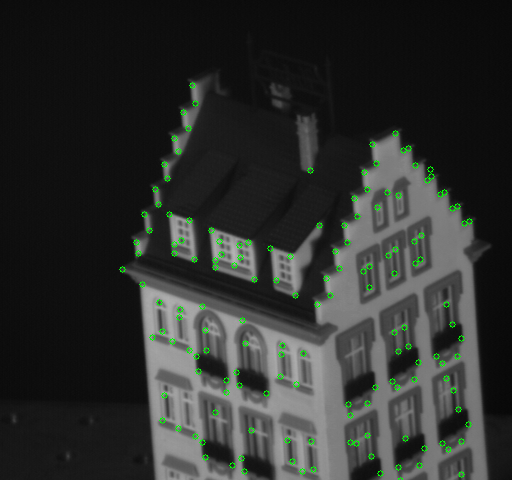

t = 41; predicting for t = 42
In function getNextPoints
t = 42; predicting for t = 43
In function getNextPoints
t = 43; predicting for t = 44
In function getNextPoints
t = 44; predicting for t = 45
In function getNextPoints
t = 45; predicting for t = 46
In function getNextPoints
t = 46; predicting for t = 47
In function getNextPoints
t = 47; predicting for t = 48
In function getNextPoints
t = 48; predicting for t = 49
In function getNextPoints
t = 49; predicting for t = 50
In function getNextPoints


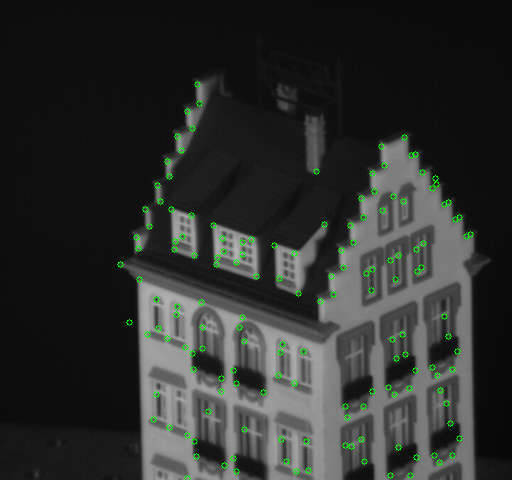

In function drawPaths
FINISHED: here are the paths of the tracked keypoints


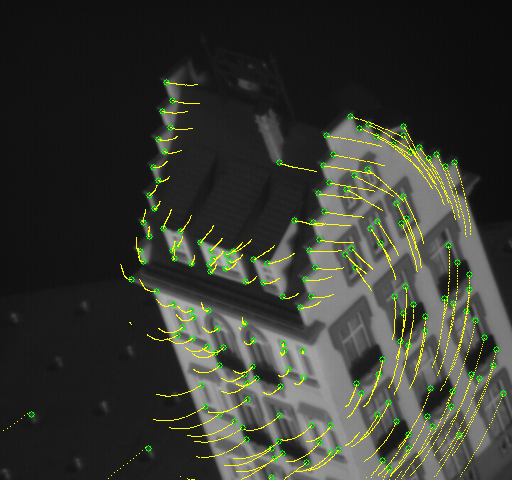

In [22]:
# Run the KLT tracking code
mainTrackingFunction()

The following is an example output from `drawPaths`. With close examination, you can see that it is not perfect for all keypoints. It is okay if your result is not perfect, either. (But try to make your output at least this good.)



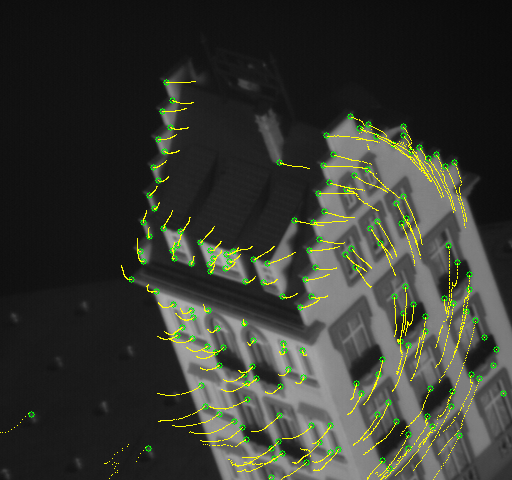



#Problem 5 - Object detection and localization using SIFT

You have been given a folder named `stopsign_images` that contains several roadside images. Your goal for this problem is to write code that can automatically detect instances of stop signs within these roadside images.

As discussed in a recent lecture, one approach is to obtain a representative example image of a stop sign, as in the file `stopsign01.jpg`. This representative case is sometimes called a "reference" image or "exemplar" image. An automated system can extract features (such as SIFT keypoints) from that reference image, and then search for corresponding features within a given "test" image (sometimes called a "query" image). Using information from the feature-matching step, this automated system must apply internal decision rule(s) to decide whether a stop sign has been found. For this problem, in addition to detecting stop signs, their locations within in the images should be reported.

Before going further, execute the following code block to verify a correct upload of these images to Google Drive, and to illustrate the use of OpenCV tools to detect SIFT keypoints. Small circles should appear to indicate keypoint locations within the reference image.

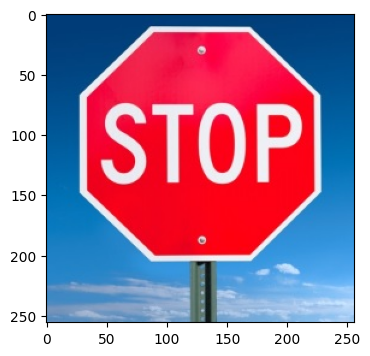

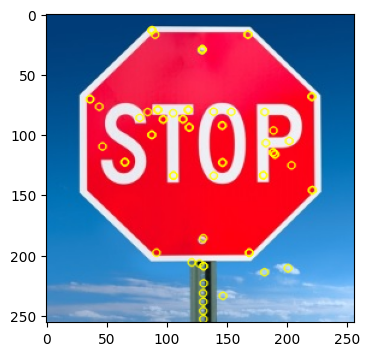

In [23]:
# Display the reference stop-sign image, with and without keypoint locations
def testSIFT(im1):
  fig = plt.figure()
  fig.set_size_inches(4, 4) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

  # Detect up to 70 keypoints and display their locations
  sift = cv2.SIFT_create(nfeatures=70)
  kp = sift.detect(im1, None)
  im1_kp = cv2.drawKeypoints(im1, kp, None, color=(0, 255, 255))

  fig = plt.figure()
  fig.set_size_inches(4, 4)
  plt.imshow(cv2.cvtColor(im1_kp, cv2.COLOR_BGR2RGB))

im_reference = cv2.imread("stopsign_images/stopsign01.jpg", cv2.IMREAD_COLOR)
testSIFT(im_reference)

Images to be used for testing have been provided to you in files named `image01.jpg`, ..., `image10.jpg`. Execute the following code block to detect  keypoints and find correspondences between the reference image and `image01.jpg`.

In [24]:
# Illustrate keypoint matching between 2 images
def genSIFTMatchPairs(img1, img2, numberOfMatches):
  # Find keypoints and their SIFT descriptors in the two images
  sift = cv2.SIFT_create()
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)

  # Search for corresponding pairs of points
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.match(des1, des2)

  # Sort correspondences based on distance (dissimilarity) between two descriptors
  matches = sorted(matches, key = lambda x:x.distance)

  pts1 = np.zeros((numberOfMatches, 2))
  pts2 = np.zeros((numberOfMatches, 2))
  for i in range(numberOfMatches):
    pts1[i,:] = kp1[matches[i].queryIdx].pt
    pts2[i,:] = kp2[matches[i].trainIdx].pt
  return pts1, pts2, matches[:numberOfMatches], kp1, kp2


def testMatchingProcedure():
  img1 = cv2.imread('stopsign_images/stopsign01.jpg')
  img2 = cv2.imread('stopsign_images/image01.jpg')

  # Perform the matching step (here, only the best 20 correspondences are returned)
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2, 20)

  # Now pts1 and pts2 should contain lists of corresponding points
  #  within img1 and img2, respectively; each point has the format [column row]
  # For exploring and debugging, you can print the corresponding pairs of points
  for match in matches1to2:
    p1 = kp1[match.queryIdx].pt
    p2 = kp2[match.trainIdx].pt
    print(p1, p2)

  # Display the two images to check the results visually
  #  (parameter flags=2 removes unmatched points from the display)
  matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches1to2, None, flags=2)
  fig = plt.figure()
  fig.set_size_inches(16, 10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))


testMatchingProcedure()

Output hidden; open in https://colab.research.google.com to view.

In this example, notice that all of the matched keypoints in the test image (`image01.jpg`) are on the large stop sign that we want to detect. That is good news! However, later you will see some matched keypoints that are not on a stop sign. More bad news is that some of the keypoints shown here have been incorrectly matched, as you can see by close examination. Possibly these false matches can be blamed on the symmetry of the stop sign.





#Object detection and localization using RANSAC

The previous steps have illustrated how you can use OpenCV and SIFT descriptors to find several pairs of corresponding points in two images. For our purposes, *any incorrect match can be considered an outlier*. As discussed in class, we can use the RANSAC approach to provide some protection from outliers.

The following pseudocode is adapted from the lecture slides, and it can guide you in writing code for this problem.  

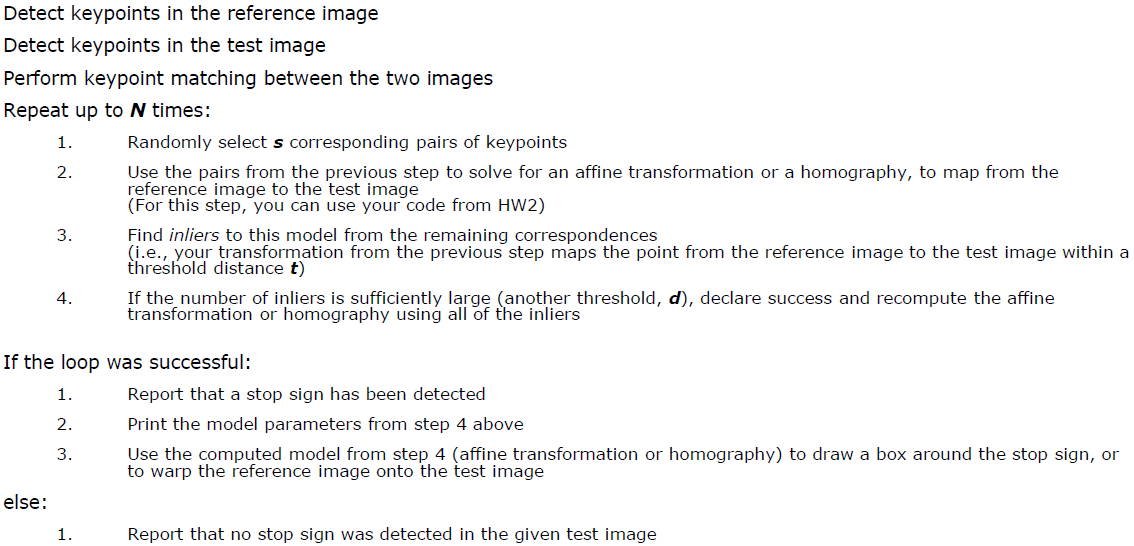

Notice that the pseudocode shown above is for a single test image. Ultimately, you should repeat the procedure for all of the test images.

You will need to decide on values for several constants that appear in this pseucode (***N***, ***s***, ***t***, etc.).  

Two ways to show your results (for successful detections) are shown below. You are not required to implement both of these methods.

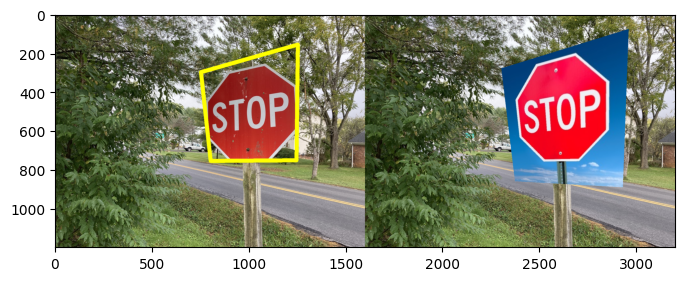

#Finding stop signs

**In the next code block, implement a system that searches for stop signs in ALL of the test images that have been provided to you.** Your system should load each test image one by one, `image01.jpg` through `image10.jpg`, and report the result for each test image as described above.

Your top-level function should be called `findStopSigns`, and it should not require any parameters to be passed to it. You are encouraged to subdivide your code into additional functions.

You must write your own version of RANSAC, instead of using library functions or code from any other source. You must also write the code that computes the transformation model (affine or homography), although here you are allowed to borrow code that *you* wrote for HW2.  

For this problem, you *are* allowed to use OpenCV functions to compute SIFT-style descriptors, as shown in the example code above. You are encouraged to experiment with different numbers of keypoints, and with different parameters to the SIFT detect-and-compute functions. In the sample code above, library call `cv2.BFmatcher` is OpenCV's "brute force" matcher, and you are welcome to try other matching techniques.  More discussion is provided in
https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html

Please write comments in your code to explain your important design decisions to the grader.


In [25]:
# function to show our images
def show_image(img):
  fig = plt.figure()
  fig.set_size_inches(8, 6)
  img = img.astype(np.uint8)
  plt.imshow(img)

# copied from above with modifications
def match_points(img_ref, img_test):

  # Perform the matching step (here, only the best 20 correspondences are returned)
  num_matches = 20
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img_ref, img_test, num_matches)

  total_p1 = np.zeros(shape=(num_matches,2))
  total_p2 = np.zeros(shape=(num_matches,2))

  # Now pts1 and pts2 should contain lists of corresponding points
  #  within img1 and img2, respectively; each point has the format [column row]
  # For exploring and debugging, you can print the corresponding pairs of points
  count = 0
  for match in matches1to2:
    p1 = kp1[match.queryIdx].pt
    p2 = kp2[match.trainIdx].pt
    total_p1[count] = p1[1], p1[0]
    total_p2[count] = p2[1], p2[0]
    count += 1


  return total_p1, total_p2

# copied my code from HW2
def compute_homography(src, dst):
  '''Computes the homography from src to dst.
   Input:
    src: source points, shape (N, 2), where N >= 4
    dst: destination points, shape (N, 2)
   Output:
    H: homography from source points to destination points, shape (3, 3)
  '''

  # SOURCE: https://math.stackexchange.com/questions/3509039/calculate-homography-with-and-without-svd

  x = []
  y = []
  x_prime = []
  y_prime = []

  # build our point matrices
  for item in range(0, len(src)):
      x.append(src.item(2 * item))
      y.append(src.item(2 * item +1 ))
      x_prime.append(dst.item(2 * item))
      y_prime.append(dst.item(2 * item + 1))
  # creates an A of necessary length
  A = np.zeros([2 * len(x), 9])

  # builds A and then finds H using SVD
  for item in range(0, (len(x))):
      A[item * 2]     = [-x[item], -y[item], -1, 0,        0,         0, x[item] * x_prime[item], y[item] * x_prime[item], x_prime[item]]
      A[item * 2 + 1] = [0,        0,         0, -x[item], -y[item], -1, x[item] * y_prime[item], y[item] * y_prime[item], y_prime[item]]
  [U, S, Vt] = np.linalg.svd(A)
  H = Vt[-1].reshape(3, 3)

  return H

# copied my code from HW2
def apply_homography(src, H):
  '''Applies a homography H to the source points.
   Input:
      src: source points, shape (N, 2)
      H: homography from source points to destination points, shape (3, 3)
   Output:
     dst: destination points, shape (N, 2)
  '''
  # creates our destination image
  dst = np.empty_like(src, dtype=np.float128)
  dst = np.asarray(dst)
  #gets the current source point
  current_src = np.empty([3, 1])
  current_src[2][0] = 1
  H_mat = np.asmatrix(H)
  for x in range(0, len(src)):
      # goes through each point in the source to find the destination point that would match
      current_src[0][0] = src.item(x*2)
      current_src[1][0] = src.item(2*x +1)

      current_src_mat = np.asmatrix(current_src)

      prime = np.matmul(H_mat, current_src_mat)
      dst[x][0] = prime.item(0)/prime.item(2)
      dst[x][1] = prime.item(1)/prime.item(2)

  return dst

In [29]:
####################################
# TO DO: Implement the function findStopSigns
#  (You are encouraged to subdivide your code into additional functions that are called by this one)
#


'''NOTE!!!!!!!
Was Unable to get a match for #6. SIFT does not do well with this particular instance and seems to fail to generate good keypoints'''

# used for generating s values
import random

def load_image(filename):
  img = np.asarray(Image.open(filename))
  img = img.astype("float32")/255.0
  return img

def findStopSigns():
  '''Examine a set of images and report locations of stop signs within those images.
     SIFT descriptors are used in the decision-making process.
   Input:
    <No input parameters. Image file names are hard-coded.>
   Output:
    <No return value. Output is provided using print statements and by displaying images.>
  '''
  print('in findStopSigns')

  # changes to rgb for necessary displaying
  img_ref = cv2.imread("stopsign_images/stopsign01.jpg", cv2.IMREAD_COLOR)
  img_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2RGB)

  # goes through each image
  count_str = ""
  for x in range(1, 11):
    if x == 10:
      count_str = "10"
    else:
      count_str = "0" + str(x)
    path = 'stopsign_images/image' + count_str + '.jpg'

    # converts other image to rgb
    img_test = cv2.imread(path, cv2.IMREAD_COLOR)
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

    # gets our matching points using sift
    p1, p2 = match_points(img_ref, img_test)

    # sets up success to be false
    success = False

    #repat up to N times
    N = 10000
    if x == 5 or x == 6:
      N = 100000
    for n in range(0, N):

      # gives us how many points we have
      end = len(p1) - 1
      count = 0

      # generates random pairs we will select
      s = random.sample(range(0, end), 6)

      # generates the numpy array of correct length
      sampled_points_ref  = np.zeros(shape=(len(s),2))
      sampled_points_test = np.zeros(shape=(len(s),2))

      # adds the points that are selected by s to our sampled point lists
      for i in s:
        sampled_points_ref[count]  = p1[i]
        sampled_points_test[count] = p2[i]
        count += 1

      #step 2 here
      # computes homography
      H = compute_homography(sampled_points_ref, sampled_points_test)

      #step 3 here
      #set t
      t = 2
      if x == 6 or x == 6:
        t = 10

      # get our index list
      inlier_index = []

      # Gives us the applied homography points vs what sift will have given us
      test_homography_points = apply_homography(p1, H)

      for point in range(0, len(p2)):
        # samples points not used by s
        if point not in s:
          # gives us sum of squared differences
          diff_x = test_homography_points[point][0] - p2[point][0]
          diff_y = test_homography_points[point][1] - p2[point][1]
          ssd    = diff_x**2 + diff_y**2
          # if ssd less than t then we will add the index
          if ssd < t:
            inlier_index.append(point)

      # builds the list of array
      inlier_point_src = np.zeros(shape=(len(inlier_index),2))
      inlier_point_dst = np.zeros(shape=(len(inlier_index),2))

      # will create our actual array of the inliers for both
      for p in range(0, len(inlier_index)):
          inlier_point_src[p] = p1[inlier_index[p]]
          inlier_point_dst[p] = p2[inlier_index[p]]

      # d value
      d = 5
      if x == 6 or x == 6:
        d = 2

      # if we reach number of inliers we re-compute H using inliers
      if len(inlier_index) >= d:
        success = True
        H = compute_homography(inlier_point_src, inlier_point_dst)

      # if we have reached a success then we move on to the next image
      if success == True:
        display_new_image(img_test, img_ref, H)
        break

    # if no match found
    if success == False:
      print("No match was found \n")

In [27]:
def display_new_image(canvas_img, src_img, H):
  # will get the destination image

  dst_img = warp_img(src_img, H, [canvas_img.shape[0], canvas_img.shape[1]])

  # perform necessary masking
  dst_mask = 1 - binary_mask(dst_img)
  dst_mask = np.stack((dst_mask,) * 3, -1)
  out_img = np.multiply(canvas_img, dst_mask) + dst_img

  # our output combined image
  show_image(out_img)

def binary_mask(img):
  '''Create a binary mask of the image content.
   Input:
    img: source image, shape (m, n, 3)
   Output:
    mask: image of shape (m, n) and type 'int'. For pixel [i, j] of mask,
      if pixel [i, j] in img is nonzero in any channel, assign 1 to mask[i, j].
      Else, assign 0 to mask[i, j].
  '''
  mask = (img[:, :, 0] > 0) | (img[:, :, 1] > 0) | (img[:, :, 2] > 0)
  mask = mask.astype("int")
  return mask

def warp_img(src_img, H, dst_img_size):
  '''Warping of a source image using a homography.
   Input:
      src_img: source image with shape (m, n, 3)
      H: homography, with shape (3, 3), from source image to destination image
      dst_img_size: height and width of destination image; shape (2,)
   Output:
      dst_img: destination image; height and width specified by dst_img_size parameter
  '''

  src_img_size = src_img.shape

  dst_img_size_mod = [dst_img_size[0], dst_img_size[1], 3]
  dst_img = np.ones(dst_img_size_mod)

  H_inverse = np.linalg.inv(H)

  # Check if the for loop ordering is correct - # TEST
  for x in range(0, dst_img_size[0]):
    for y in range(0, dst_img_size[1]):

      #use x,y instead of [x][y]
      # need to stick x, y, 1 for a 3x1 matrix
      #so basically, think of x, y, 1 as the cordinates we have, then use H-inverse to map back to the src image and get the intensity from that specific pixel
      destination_matrix = np.array([x, y, 1])

      src_image_point = np.matmul(H_inverse, destination_matrix)


      x_src = int(src_image_point.item(0) / src_image_point.item(2))
      y_src = int(src_image_point.item(1) / src_image_point.item(2))

      #basically, if the bounds are not relevant (outside of where it can be placed), we want to set to 0

      if x_src > dst_img_size[0]-1 or y_src > dst_img_size[1]-1 or x_src < 0 or y_src < 0 or x_src > src_img_size[0]-1 or y_src > src_img_size[1]-1:
        intensity = [0, 0, 0]
        #dst_img[x, y] = intensity
      else:
        intensity = src_img[x_src][y_src]
        temp = intensity
        #if temp[0]!= 0 and temp[1]!= 0 and temp[2]!= 0:
          #print(x_src, y_src)
        #dst_img[y, x] = intensity

      # set the intensity of that point
      dst_img[x, y] = intensity

  return dst_img

**Sign detection test**

The grader should only need to run **`findStopSigns`** in the next block in order to run your code and see the required output.

In [36]:
# Run the sign-detection code
findStopSigns()

Output hidden; open in https://colab.research.google.com to view.

# Problem 6: Extra credit (up to 10 points) for ECE 4554 *and ECE 5554*

Pick one of the following problems and submit your solution.  Also provide a short write-up (maybe 1 or 2 pages) that describes your work for this problem. Place that discussion after your analytical problems, at the end of document `Homework4_Problems1-3_USERNAME.pdf`.

a) Implement your own version of a SIFT-like local descriptor. For reference, see the lecture materials and Szeliski 7.1.2. You may simplify the design by changing the window sizes, the number of histogram bins, etc. (As motivation, one of my previous graduate students obtained better results in his research when he used the RootSIFT approach that is described in Szeliski.) Demonstrate the operation of your new descriptor by repeating  Problem 5 using your new descriptor. In your write-up, compare the  performance of your new descriptor relative to the OpenCV implementation.

b) Repeat  Problem 5 using one or two other descriptors that are provided in OpenCV. (ORB, for example.) In your write-up, compare the relative performance of all descriptors that you tried.



In [33]:
# Illustrate keypoint matching between 2 images
def genORBMatchPairs(img1, img2, numberOfMatches):
  # Find keypoints and their SIFT descriptors in the two images
  orb = cv2.ORB_create()
  kp1, des1 = orb.detectAndCompute(img1, None)
  kp2, des2 = orb.detectAndCompute(img2, None)

  # Search for corresponding pairs of points
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.match(des1, des2)

  # Sort correspondences based on distance (dissimilarity) between two descriptors
  matches = sorted(matches, key = lambda x:x.distance)

  pts1 = np.zeros((numberOfMatches, 2))
  pts2 = np.zeros((numberOfMatches, 2))
  for i in range(numberOfMatches):
    pts1[i,:] = kp1[matches[i].queryIdx].pt
    pts2[i,:] = kp2[matches[i].trainIdx].pt
  return pts1, pts2, matches[:numberOfMatches], kp1, kp2


# copied from above with modifications
def match_points_orb(img_ref, img_test):

  # Perform the matching step (here, only the best 20 correspondences are returned)
  num_matches = 20
  pts1, pts2, matches1to2, kp1, kp2 = genORBMatchPairs(img_ref, img_test, num_matches)

  total_p1 = np.zeros(shape=(num_matches,2))
  total_p2 = np.zeros(shape=(num_matches,2))

  # Now pts1 and pts2 should contain lists of corresponding points
  #  within img1 and img2, respectively; each point has the format [column row]
  # For exploring and debugging, you can print the corresponding pairs of points
  count = 0
  for match in matches1to2:
    p1 = kp1[match.queryIdx].pt
    p2 = kp2[match.trainIdx].pt
    total_p1[count] = p1[1], p1[0]
    total_p2[count] = p2[1], p2[0]
    count += 1

  return total_p1, total_p2

In [43]:
####################################
# TO DO: Implement the function findStopSigns
#  (You are encouraged to subdivide your code into additional functions that are called by this one)
#


'''NOTE!!!!!!!
Was Unable to get a match for #6. SIFT does not do well with this particular instance and seems to fail to generate good keypoints'''

# used for generating s values
import random

def load_image(filename):
  img = np.asarray(Image.open(filename))
  img = img.astype("float32")/255.0
  return img

def finalMainFunction():
  '''Examine a set of images and report locations of stop signs within those images.
     SIFT descriptors are used in the decision-making process.
   Input:
    <No input parameters. Image file names are hard-coded.>
   Output:
    <No return value. Output is provided using print statements and by displaying images.>
  '''
  print('in finalMainFunction')

  # changes to rgb for necessary displaying
  img_ref = cv2.imread("stopsign_images/stopsign01.jpg", cv2.IMREAD_COLOR)
  img_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2RGB)

  # goes through each image
  count_str = ""
  for x in range(1, 11):
    if x == 10:
      count_str = "10"
    else:
      count_str = "0" + str(x)
    path = 'stopsign_images/image' + count_str + '.jpg'

    # converts other image to rgb
    img_test = cv2.imread(path, cv2.IMREAD_COLOR)
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

    # gets our matching points using sift
    p1, p2 = match_points_orb(img_ref, img_test)

    # sets up success to be false
    success = False

    #repat up to N times
    N = 10000
    if x == 5 or x == 6:
      N = 100000
    for n in range(0, N):

      # gives us how many points we have
      end = len(p1) - 1
      count = 0

      # generates random pairs we will select
      s = random.sample(range(0, end), 6)

      # generates the numpy array of correct length
      sampled_points_ref  = np.zeros(shape=(len(s),2))
      sampled_points_test = np.zeros(shape=(len(s),2))

      # adds the points that are selected by s to our sampled point lists
      for i in s:
        sampled_points_ref[count]  = p1[i]
        sampled_points_test[count] = p2[i]
        count += 1

      #step 2 here
      # computes homography
      H = compute_homography(sampled_points_ref, sampled_points_test)

      #step 3 here
      #set t
      t = 2
      if x == 6 or x == 6:
        t = 10

      # get our index list
      inlier_index = []

      # Gives us the applied homography points vs what sift will have given us
      test_homography_points = apply_homography(p1, H)

      for point in range(0, len(p2)):
        # samples points not used by s
        if point not in s:
          # gives us sum of squared differences
          diff_x = test_homography_points[point][0] - p2[point][0]
          diff_y = test_homography_points[point][1] - p2[point][1]
          ssd    = diff_x**2 + diff_y**2
          # if ssd less than t then we will add the index
          if ssd < t:
            inlier_index.append(point)

      # builds the list of array
      inlier_point_src = np.zeros(shape=(len(inlier_index),2))
      inlier_point_dst = np.zeros(shape=(len(inlier_index),2))

      # will create our actual array of the inliers for both
      for p in range(0, len(inlier_index)):
          inlier_point_src[p] = p1[inlier_index[p]]
          inlier_point_dst[p] = p2[inlier_index[p]]

      # d value
      d = 6
      if x == 6 or x == 6:
        d = 2

      # if we reach number of inliers we re-compute H using inliers
      if len(inlier_index) >= d:
        success = True
        H = compute_homography(inlier_point_src, inlier_point_dst)

      # if we have reached a success then we move on to the next image
      if success == True:
        display_new_image(img_test, img_ref, H)
        break

    # if no match found
    if success == False:
      print("No match was found \n")

**Extra credit execution**

The grader should only need to run **`finalMainFunction`** in the next block in order to run your code and see the required output.

In [44]:
# Run the extra-credit code
finalMainFunction()

in finalMainFunction
No match was found 

No match was found 

No match was found 

No match was found 

No match was found 

No match was found 

No match was found 

No match was found 

No match was found 

No match was found 



---
# Creating a PDF version of your current notebook

In [45]:
#The following two installation steps are needed to generate a PDF version of the notebook
#(These lines are needed within Google Colab, but are not needed within a local version of Jupyter notebook)
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc
!pip install --quiet pypandoc

Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fonts-droid-fallback.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../00-fonts-droid-fallback_1%3a6.0.1r16-1.1build1_all.deb ...
Unpacking fonts-droid-fallback (1:6.0.1r16-1.1build1) ...
Selecting previously unselected package fonts-lato.
Preparing to unpack .../01-fonts-lato_2.0-2.1_all.deb ...
Unpacking fonts-lato (2.0-2.1) ...
Selecting previously unselected package poppler-data.
Preparing to unpack .../02-poppler-data_0.4.11-1_all.deb ...
Unpacking poppler-data (0.4.11-1) ...
Selecting previously unselected package tex-common.
Preparing to unpack .../03-tex-common_6.17_all.deb ...
Unpacking tex-common (6.17) ...
Selecting previously unselected package fonts-urw-base35.
Preparing to unpack .../04-fonts-urw-base35_20200910-1_all.deb ...
Unpacking fonts-urw-base35 (20200910-1) ...
Selecting previously unselected package libgs9-co

In [46]:
# TO DO: Provide the full path to your Jupyter notebook file
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Computer Vision/Homework4_benakhtar.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Computer Vision/Homework4_benakhtar.ipynb to PDF
[NbConvertApp] Support files will be in Homework4_benakhtar_files/
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Making directory ./Homework4_benakhtar_files
[NbConvertApp] Writing 147070 bytes to noteboo